### **Model Training with Federated Learning**

In [1]:
# Install required packages
import pandas as pd
import numpy as np
import time
import os
import keras
import json
from flwr.client import ClientApp
import tensorflow as tf
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
import flwr as fl
from keras import layers, Sequential, optimizers, metrics
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
import flwr as fl
from flwr.common import Scalar, NDArrays, Context, Metrics
from typing import Dict, Tuple, Any, List
from functools import partial
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

# Enable TensorFlow GPU memory growth
enable_tf_gpu_growth()

In [2]:
SAVE_DIR = "saved_fl_models"
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Define the data directories of different scenarios
# scenario_name: 'path/to/data'
data_dirs = {
    'covid_response': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response',
    'covid_response_weather': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response_weather',
    'covid_response_weather_avg_neighbour': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response_weather_avg_neighbour',
    'covid_response_weather_avg_neighbour_vaccination': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response_weather_avg_neighbour_vaccination',
    'covid_response_weather_avg_neighbour_vaccination_testing': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/covid_response_weather_avg_neighbour_vaccination_testing',
    'fl_vs_centralized': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/fl_vs_centralized',
    'fl_vs_single_country': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/fl_vs_single_country',
    'group_central': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/group_central',
    'group_eastern': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/group_eastern',
    'group_nordic': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/group_nordic',
    'group_southern': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/group_southern',
    'min_feature_set': 'D:/Masterarbeit/Data/Kullanacagim_Data/Preprocessed_Files/equal_columns/Scenarios/min_feature_set',
}

In [3]:
# Define helper functions

def load_data(scenario):
    """
    Load individual csv files according to given scenario. and save them to pandas DataFrames.
    """
    
    scenario_dir = data_dirs[scenario]
    country_dfs = {}

    for filename in os.listdir(scenario_dir):
        if filename.endswith('.csv'):
            country = filename.replace('.csv', '')
            filepath = os.path.join(scenario_dir, filename)
            country_dfs[country] = pd.read_csv(filepath)

    return country_dfs

# Prepare the data for neural network training

def prepare_data(country_df_original):
    '''
    Rescales the data for the neural network training.

    Args:
        country_df_original (pd.DataFrame): DataFrame for a single country.

    Returns:
        train_scaled_np, val_scaled_np, test_scaled_np, scaler_object, Num_sequences
               Returns (None, None, None, None) if data is insufficient or errors occur.

    '''
    country_data = country_df_original.copy()

    country_data = country_data.set_index('date', drop=True).sort_index()

    target_column_index = country_data.columns.get_loc('confirmed')

    # Remove some of the columns that are common in all datasets and constant across all rows
    # Constant_columns = ['country_region', 'Schengen', 'EU', 'EEA', 'PopDensity', 'avg_neighbour_deaths', 'gini_index', 'vulnerable_pop_percentage']
    # country_data = country_data.drop(columns=Constant_columns)

    Num_features = country_data.shape[1]

    # Transform numerical values to float32 type
    country_data = country_data.astype(np.float32)

    # Split the data into train, validation, and test sets
    train_size = int(len(country_data) * 0.8)
    val_size = int(len(country_data) * 0.1)

    # Ensure there's enough data for all splits
    if len(country_data) < train_size + val_size + 1: # Need at least 1 for test
        print("Warning: Insufficient data to create train, validation, and test sets.")
        return None, None, None, None

    train_data = country_data[:train_size]
    val_data = country_data[train_size:train_size + val_size]
    test_data = country_data[train_size + val_size:]

    if train_data.empty or val_data.empty or test_data.empty:
        print("Warning: One or more data splits are empty after partitioning.")
        return None, None, None, None

    # Rescale the data with Z-score normalization

    scaler = StandardScaler()

    train_data_scaled = scaler.fit_transform(train_data)
    train_data_scaled = np.nan_to_num(train_data_scaled, nan=0.0)
    val_data_scaled = scaler.transform(val_data)
    val_data_scaled = np.nan_to_num(val_data_scaled, nan=0.0)
    test_data_scaled = scaler.transform(test_data)
    test_data_scaled = np.nan_to_num(test_data_scaled, nan=0.0)

    return train_data_scaled, val_data_scaled, test_data_scaled, scaler, Num_features, target_column_index

def create_sequences(data_scaled, lookback_window, forecast_horizon, target_column_index):
    '''
    Create sequences for the LSTM model
    Args:
        data_scaled (np.array): Scaled data.
        lookback_window (int): Number of previous time steps to consider.
        target_column_index (int): Index of the target column in the data.
        forecast_horizon (int): Number of time steps to forecast.
    Returns:
        tuple: (np.array of sequences, np.array of targets)) y will have the shape (num of sequences, forecast_horizon) 
    '''
    
    X, y = [], []

    if len(data_scaled) <= lookback_window + forecast_horizon:
        print("Warning: Not enough data to create sequences. Can not create sufficient sequences")
        return np.array(X), np.array(y)
    
    for i in range(len(data_scaled) - lookback_window- forecast_horizon + 1):
        X.append(data_scaled[i:i + lookback_window])
        y.append(data_scaled[i + lookback_window: i + lookback_window + forecast_horizon, target_column_index])
    return np.array(X), np.array(y)

In [4]:
# Germany as the representative country for hyperparameter tuning

# Load Germany's data for all four scenarios: withoutvaccination and test data, only test data, only vaccination data, both vaccination and test data

Germany = pd.read_csv(os.path.join(data_dirs['covid_response_weather_avg_neighbour_vaccination_testing'], 'Germany.csv'))

data_dict = {
    'covid_response_weather_avg_neighbour_vaccination_testing': Germany,
}

FORECAST_HORIZON = 10
LOOKBACK_WINDOW = 21

In [5]:
# Define the LSTM model function

# kernel initializer: how weights are initialized

def get_LSTM(lookback, n_features, num_layers_hp, units_list_hp, dropout_hp, lr_hp, activation_hp, 
             kernel_initializer_hp, loss_func_hp='mean_squared_error', 
             metrics_list=[metrics.MeanAbsoluteError(),metrics.RootMeanSquaredError()], 
             forecast_horizon=1):
    """
    Define the LSTM model architecture.

    Args:
        lookback (int): Number of time steps for input.
        n_features (int): Number of features in the input data.
        num_layers_hp (int): Number of LSTM layers.
        units_list_hp (list): List of integers, number of units for each LSTM layer.
        dropout_hp (float): Dropout rate after each LSTM layer.
        lr_hp (float): Learning rate for the optimizer.
        activation_hp (str): Activation function for LSTM layers.
        loss_func (str): Loss function for compiling the model.
        kernel_initializer_hp (str): Kernel initializer for LSTM layers.
        metrics_list (list): List of metrics for compiling the model.
        forecast_horizon (int): Number of time steps to forecast. Default is 1 we change it later on.
    Returns:
        A compiled Keras Sequential model.
    """
    
    model = Sequential()
    model.add(layers.Input(shape=(lookback, n_features)))

    if len(units_list_hp) != num_layers_hp:
        raise ValueError("Length of units_list_hp must match num_layers_hp.")

    for i in range(num_layers_hp):
        # Return sequences for all LSTM layers except the last one
        return_sequences = True if i < num_layers_hp - 1 else False
        model.add(layers.LSTM(
            units=units_list_hp[i],
            activation=activation_hp,
            kernel_initializer=kernel_initializer_hp,
            return_sequences=return_sequences 
        ))
        model.add(layers.Dropout(dropout_hp))

    # Assuming you are predicting one target variable for the next time step.
    model.add(layers.Dense(forecast_horizon)) 

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr_hp),
        loss=loss_func_hp,
        metrics=metrics_list
    )
    return model

In [6]:
# Tuning of the hyperparamters of the LSTM model

# Parameters to be included in the hyperparameter tuning: number of hidden layers, number of neurons in each hidden layer, dropout rate,
# learning rate, activation function.

def build_keras_tuner(hp: kt.HyperParameters, lookback, n_features) -> keras.Model:
    """
    Builds and compiles an LSTM model with hyperparameters defined by Keras Tuner.
    This function is intended to be passed to a Keras Tuner instance.
    
    Args:
        hp: Keras Tuner HyperParameters object.
        lookback (int): The lookback window size for LSTM (fixed for a tuning session).
        n_features (int): The number of features in the input data (fixed for a tuning session).
        
    Returns:
        A compiled Keras model.
    """

    # Define hyperparameter search space
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=4, step=1, default=1)

    units_l1 = hp.Int('units_l1', min_value=32, max_value=256, step=32, default=64)
    units_l2 = hp.Int('units_l2', min_value=32, max_value=256, step=32, default=64)
    units_l3 = hp.Int('units_l3', min_value=32, max_value=256, step=32, default=64)
    units_l4 = hp.Int('units_l4', min_value=32, max_value=256, step=32, default=64)

    all_possible_units = [units_l1, units_l2, units_l3, units_l4]

    # Create the list of units to be used for the current number of layers
    units_for_this_model = [all_possible_units[i] for i in range(num_hidden_layers)]


    dropout_rate_hp = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1, default=0.2)
    learning_rate_hp = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=1e-3)
    activation_function_hp = hp.Choice('activation_function', values=['relu', 'tanh'], default='relu')
    
    # Add kernel initializer to tuning
    kernel_initializer_choice = hp.Choice('kernel_initializer', 
                                          values=['glorot_uniform', 'he_normal', 'orthogonal'], 
                                          default='glorot_uniform')
    
    # Add loss function to tuning
    loss_function_choice = hp.Choice('loss_function', 
                                     values=['mean_squared_error', 'mean_absolute_error'], 
                                     default='mean_squared_error')
    
    # Build the model using get_LSTM
    model = get_LSTM(
        lookback=lookback,
        n_features=n_features,
        num_layers_hp=num_hidden_layers,
        units_list_hp=units_for_this_model,
        dropout_hp=dropout_rate_hp,
        lr_hp=learning_rate_hp,
        activation_hp=activation_function_hp,
        kernel_initializer_hp=kernel_initializer_choice, # Pass tuned kernel initializer
        loss_func_hp=loss_function_choice, # Pass tuned loss function
        forecast_horizon=FORECAST_HORIZON 
    )
    
    return model

In [7]:
# Do the hyperparameter tuning for each scenario in a loop:
start_time_hps = time.time()
for scenario, country_df in data_dict.items():
    print(f"Starting hyperparameter tuning for scenario: {scenario}")

    # Prepare the data
    train_scaled_np, val_scaled_np, test_scaled_np, scaler, Num_features, target_column_index = prepare_data(country_df)
    
    if train_scaled_np is None or val_scaled_np is None or test_scaled_np is None:
        print(f"Skipping scenario {scenario} due to insufficient data.")
        continue

    # Ensure N_FEATURES is derived correctly after potential None checks
    if train_scaled_np.ndim < 2 or train_scaled_np.shape[1] == 0:
        print(f"Skipping scenario {scenario} due to invalid shape of scaled training data.")
        continue
    
    
    # Create sequences
    X_train, y_train = create_sequences(train_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)
    X_val, y_val = create_sequences(val_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)
    X_test, y_test = create_sequences(test_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)

    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        print(f"Skipping scenario {scenario} due to insufficient sequences.")
        continue

    # Create a partial function for the hypermodel
    hypermodel_fn = partial(build_keras_tuner, lookback=LOOKBACK_WINDOW, n_features=Num_features)

    tuner_project_dir = 'tuner_results' # Keras Tuner will store its detailed logs here
    # Define the hyperparameter tuner
    tuner = kt.Hyperband(
        hypermodel_fn,
        objective=kt.Objective("val_root_mean_squared_error", direction="min"),
        max_epochs=50,
        factor=3,
        directory=tuner_project_dir,
        project_name=f'LSTM_tuning_{scenario}'
    )

    # Define an early stopping callback for the tuning process
    early_stopping_tuning = keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=10, 
    restore_best_weights=True
    )

    # Search for the best hyperparameters
    print(f"Starting hyperparameter search for scenario {scenario}...")
    tuner.search(X_train, y_train,
                 epochs=50,
                 validation_data=(X_val, y_val),
                 callbacks=[early_stopping_tuning],
                 verbose=1)
    
    end_time_hps = time.time()
    training_time_hps = end_time_hps - start_time_hps
    print(training_time_hps)
    
    # Get the best model and hyperparameters
    best_models = tuner.get_best_models(num_models=1)
    if not best_models:
        print(f"No best model found for scenario {scenario}. Skipping saving.")
        continue
    best_model = best_models[0]

    best_hyperparameters_obj = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_hyperparameters_dict = best_hyperparameters_obj.values

    print(f"Best hyperparameters for scenario {scenario}: {best_hyperparameters_dict}")

    # ---- SAVING THE MODEL AND HYPERPARAMETERS ----
    model_save_path = os.path.join(SAVE_DIR, f"best_model_{scenario}.keras") # Use .keras format
    best_model.save(model_save_path)
    print(f"Saved best model for {scenario} to {model_save_path}")

    hyperparams_save_path = os.path.join(SAVE_DIR, f"best_hyperparameters_{scenario}.json")
    with open(hyperparams_save_path, 'w') as f:
        json.dump(best_hyperparameters_dict, f, indent=4)
    print(f"Saved best hyperparameters for {scenario} to {hyperparams_save_path}")

    # For clarity
    print("-" * 50)

print("Hyperparameter tuning and model saving complete for all scenarios.")

Trial 90 Complete [00h 00m 19s]
val_root_mean_squared_error: 1.0539782047271729

Best val_root_mean_squared_error So Far: 0.496410995721817
Total elapsed time: 00h 15m 36s
936.1598176956177
Best hyperparameters for scenario covid_response_weather_avg_neighbour_vaccination_testing: {'num_hidden_layers': 1, 'units_l1': 96, 'units_l2': 96, 'units_l3': 96, 'units_l4': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.001, 'activation_function': 'relu', 'kernel_initializer': 'he_normal', 'loss_function': 'mean_absolute_error', 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0078'}
Saved best model for covid_response_weather_avg_neighbour_vaccination_testing to saved_fl_models\best_model_covid_response_weather_avg_neighbour_vaccination_testing.keras
Saved best hyperparameters for covid_response_weather_avg_neighbour_vaccination_testing to saved_fl_models\best_hyperparameters_covid_response_weather_avg_neighbour_vaccination_te

We learned the best hyperparameters with Keras tuner hyperparameter optimization. Next, we are going to use those hyperparameters in our federated learning training where central server will be initializing the hyperparameters and then share those with the client nodes.

In [8]:
# Define the FlowerClient class and client_fn for federated learning

class CovidFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid: str, X_train: np.ndarray, y_train: np.ndarray, 
                 X_val: np.ndarray, y_val: np.ndarray, X_test: np.ndarray, 
                 y_test: np.ndarray, hps: Dict[str, Any], n_features: int, 
                 lookback: int, forecast_horizon: int):
        
        self.cid = cid
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.hps = hps
        self.n_features = n_features
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon
        self.model = None
    
    def _build_model(self):

        # Construct units_list_hp from hps
        num_hidden_layers = self.hps['num_hidden_layers']

        final_units_list = [self.hps[f"units_l{i+1}"] for i in range(num_hidden_layers)]

        self.model = get_LSTM(
            lookback=self.lookback,
            n_features=self.n_features,
            num_layers_hp=self.hps["num_hidden_layers"],
            units_list_hp=final_units_list,
            dropout_hp=self.hps["dropout_rate"],
            lr_hp=self.hps["learning_rate"],  # Initial learning rate for compilation
            activation_hp=self.hps["activation_function"],
            kernel_initializer_hp=self.hps["kernel_initializer"],
            loss_func_hp=self.hps["loss_function"],
            forecast_horizon=self.forecast_horizon
        )
    
    def get_parameters(self, config: Dict[str, Scalar]) -> NDArrays:
        if self.model is None:
            self._build_model()
        return self.model.get_weights()
    
    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[NDArrays, int, Dict[str, Scalar]]:
        if self.model is None:
            self._build_model()

        self.model.set_weights(parameters)

        # Client-side early stopping
        early_stopping_cb = keras.callbacks.EarlyStopping(
            monitor='val_loss',  # Assuming 'val_loss' is available if X_val, y_val used
            patience=5,          # Number of epochs with no improvement after which training will be stopped.
            restore_best_weights=True
        )
        
        # Check if validation data is available
        validation_data = None
        if self.X_val is not None and len(self.X_val) > 0 and \
           self.y_val is not None and len(self.y_val) > 0:
            validation_data = (self.X_val, self.y_val)

        history = self.model.fit(
            self.X_train, self.y_train,
            epochs=int(config["local_epochs"]),
            batch_size=int(config["batch_size"]),
            validation_data=validation_data,
            callbacks=[early_stopping_cb] if validation_data else [],
            verbose=1  # Suppress detailed Keras output for cleaner FL logs
        )
        
        # Extract metrics from the last epoch
        results = {
            "loss": history.history["loss"][-1],
        }
        if validation_data:
            results["val_loss"] = history.history["val_loss"][-1]
            results["val_rmse"] = history.history["val_root_mean_squared_error"][-1]
            results["val_mae"] = history.history["val_mean_absolute_error"][-1]


        return self.model.get_weights(), len(self.X_train), results
    
    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[float, int, Dict[str, Scalar]]:
        if self.model is None:
            self._build_model()

        self.model.set_weights(parameters)

        # Ensure test data is available
        if self.X_test is None or len(self.X_test) == 0 or \
           self.y_test is None or len(self.y_test) == 0:
            # Return zero loss, zero samples, and empty metrics if no test data
            return 0.0, 0, {}

        loss, rmse, mae = self.model.evaluate(
            self.X_test, self.y_test,
            batch_size=int(config.get("batch_size", 32)), # Use batch_size from config or default
            verbose=1
        )
        return float(loss), len(self.X_test), {"rmse": float(rmse), "mae": float(mae)}

In [9]:
def get_client_fn(Data_dict, hps: Dict[str, Any], n_features: int, lookback: int, forecast_horizon: int):

    country_keys_list: List[str] = sorted(list(Data_dict.keys()))

    def client_fn(context: Context):

        partition_id: int = context.node_config["partition-id"]

        if partition_id >= len(country_keys_list):
            raise IndexError(
                f"partition_id {partition_id} is out of bounds for country_keys_list "
                f"(length {len(country_keys_list)}). "
                f"Ensure num_supernodes in run_simulation does not exceed the "
                f"number of unique data partitions (countries: {len(country_keys_list)})."
            )
        
        country_name_for_client: str = country_keys_list[partition_id]

        print(f"[Client Factory] Client with partition_id {partition_id} assigned to data for country: {country_name_for_client}") # For debugging
        

        X_train, y_train, X_val, y_val, X_test, y_test = Data_dict[country_name_for_client]

        return CovidFlowerClient(cid = country_name_for_client, X_train=X_train, y_train = y_train, X_val = X_val, y_val=y_val, X_test=X_test, 
                                 y_test=y_test, lookback=lookback, n_features=n_features, hps=hps,forecast_horizon=forecast_horizon).to_client()
    
    return client_fn



In [10]:
# Custom aggregation function for fit metrics
def fit_metrics_aggregation_fn(all_client_metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregate metrics from the fit stage using weighted average."""
    aggregated_fit_metrics = {}
    # Metrics returned by CovidFlowerClient.fit in the 'results' dictionary
    metric_keys_to_aggregate = ["loss", "val_loss", "val_rmse", "val_mae"] 
    
    for key in metric_keys_to_aggregate:
        # Collect metrics for the current key from all clients that reported it
        key_specific_metrics = []
        for num_examples, metrics_dict in all_client_metrics:
            if metrics_dict and key in metrics_dict: # Check if metrics_dict is not None
                key_specific_metrics.append((num_examples, metrics_dict[key]))
        
        if key_specific_metrics:
            # Calculate weighted average for this specific metric
            total_examples_for_key = sum(ex for ex, _ in key_specific_metrics)
            if total_examples_for_key > 0:
                weighted_sum = sum(ex * val for ex, val in key_specific_metrics)
                # Prefix with 'fit_' to distinguish in logs/history
                aggregated_fit_metrics[f"fit_{key}"] = weighted_sum / total_examples_for_key
            elif key_specific_metrics: # All num_examples are 0, but values exist
                # Calculate simple average if values exist
                simple_avg = sum(val for _, val in key_specific_metrics) / len(key_specific_metrics)
                aggregated_fit_metrics[f"fit_{key}"] = simple_avg
                
    return aggregated_fit_metrics


# Custom aggregation function for evaluate metrics
def evaluate_metrics_aggregation_fn(all_client_metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregate metrics from the evaluate stage using weighted average."""
    aggregated_eval_metrics = {}
    # Metrics returned by CovidFlowerClient.evaluate in the metrics dictionary
    metric_keys_to_aggregate = ["rmse", "mae"] 
    
    for key in metric_keys_to_aggregate:
        key_specific_metrics = []
        for num_examples, metrics_dict in all_client_metrics:
            # Ensure metrics_dict is not None and key exists
            if metrics_dict and key in metrics_dict:
                key_specific_metrics.append((num_examples, metrics_dict[key]))
        
        if key_specific_metrics:
            total_examples_for_key = sum(ex for ex, _ in key_specific_metrics)
            if total_examples_for_key > 0:
                weighted_sum = sum(ex * val for ex, val in key_specific_metrics)
                # Prefix with 'eval_' to distinguish in logs/history
                aggregated_eval_metrics[f"eval_{key}"] = weighted_sum / total_examples_for_key
            elif key_specific_metrics: # All num_examples are 0, but values exist
                simple_avg = sum(val for _, val in key_specific_metrics) / len(key_specific_metrics)
                aggregated_eval_metrics[f"eval_{key}"] = simple_avg
                
    return aggregated_eval_metrics

In [11]:
def get_server_fn(num_rounds: int, num_total_clients: int,
                  initial_learning_rate: float, local_epochs: int, batch_size: int,
                  ):

    def fit_config_fn(server_round: int) -> Dict[str, Scalar]:
        """Return training configuration dict for each round."""
        # Here you can implement more complex logic, e.g., learning rate scheduling
        config = {
            "learning_rate": initial_learning_rate,
            "local_epochs": local_epochs,
            "batch_size": batch_size,
        }
        return config

    def evaluate_config_fn(server_round: int) -> Dict[str, Scalar]:
        """Return evaluation configuration dict for each round."""
        # Pass batch_size for evaluation, or other eval-specific params
        config = {
            "batch_size": batch_size,
        }
        return config
    
    def server_fn(context: Context):

        strategy = FedAvg(
            fraction_fit=1.0,
            fraction_evaluate=1.0,
            min_fit_clients=num_total_clients,
            min_evaluate_clients=num_total_clients,
            min_available_clients=num_total_clients,
            on_fit_config_fn=fit_config_fn,       # Pass the config function for fit
            on_evaluate_config_fn=evaluate_config_fn, # Pass the config function for evaluate
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )

        config = ServerConfig(num_rounds=num_rounds)

        return ServerAppComponents(strategy=strategy, config=config)
    
    return server_fn

In [12]:
start_time_fl = time.time()

SCENARIO = 'covid_response_weather_avg_neighbour_vaccination_testing'

# backend_config = {"client_resources": {"num_cpus": 4.0, "num_gpus": 1.0}}

FL_NUM_ROUNDS = 50
FL_LOCAL_EPOCHS = 1
FL_BATCH_SIZE = 32

# Main FL Training

# Prepare the data
country_dfs = load_data(SCENARIO) # A dict
num_actual_clients = len(country_dfs)

node_dict = {}
hps_dict = {}

hps_directory = r"D:\Masterarbeit\Code\Final Simulations\covid_response_weather_avg_neighbour_vaccination_testing\saved_fl_models"

In [ ]:
start_time_fl = time.time()

SCENARIO = 'covid_response_weather_avg_neighbour_vaccination_testing'

# backend_config = {"client_resources": {"num_cpus": 4.0, "num_gpus": 1.0}}

FL_NUM_ROUNDS = 50
FL_LOCAL_EPOCHS = 1
FL_BATCH_SIZE = 32

# Main FL Training

# Prepare the data
country_dfs = load_data(SCENARIO) # A dict
num_actual_clients = len(country_dfs)

node_dict = {}
hps_dict = {}

hps_directory = r"D:\Masterarbeit\Code\Final Simulations\covid_response_weather_avg_neighbour_vaccination_testing\saved_fl_models"

for filename in os.listdir(hps_directory):
    if filename.endswith(".json") and filename.startswith("best_hyperparameters_"):
        # Extract the key from the filename
        file_key = filename.replace("best_hyperparameters_", "").replace(".json", "")
        # Or in Python 3.9+: file_key = filename.removeprefix("best_hyperparameters_").removesuffix(".json")

        filepath = os.path.join(hps_directory, filename)
        with open(filepath, "r") as f:
            try:
                hyperparams = json.load(f)
                hps_dict[file_key] = hyperparams
            except json.JSONDecodeError as e:
                print(f"Error decoding {filename}: {e}")
        break

if SCENARIO not in hps_dict:
    raise ValueError(f"Hyperparameters for scenario '{SCENARIO}' not found in {hps_directory}")

hps = hps_dict[SCENARIO]
fl_initial_lr = hps["learning_rate"]

server_fn = get_server_fn(
    num_rounds=FL_NUM_ROUNDS,
    num_total_clients=num_actual_clients, # Use actual number of clients
    initial_learning_rate=fl_initial_lr,
    local_epochs=FL_LOCAL_EPOCHS,
    batch_size=FL_BATCH_SIZE,
)
server = ServerApp(server_fn=server_fn)

for country_name, df in country_dfs.items():

    train_scaled_np, val_scaled_np, test_scaled_np, scaler_, Num_features, target_column_index = prepare_data(df)

    x_train, y_train = create_sequences(train_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)
    x_val, y_val = create_sequences(val_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)
    x_test, y_test = create_sequences(test_scaled_np, LOOKBACK_WINDOW, FORECAST_HORIZON, target_column_index)

    

    if len(x_train) == 0:
        print(f"Warning: Client {country_name} has no training sequences. Skipping this client for FL.")
        num_actual_clients -= 1 # Adjust if you are dynamically setting num_total_clients
        continue # Skip adding to node_dict
    
    # Store everything in a dictionary keyed by country name
    node_dict[country_name] = (x_train, y_train, x_val, y_val, x_test, y_test)


_, _, _, _, Num_features, _ = prepare_data(country_dfs['Germany'])


client_fn = get_client_fn(Data_dict=node_dict, hps=hps, n_features=Num_features,
                           lookback=LOOKBACK_WINDOW, forecast_horizon=FORECAST_HORIZON)

client = ClientApp(client_fn=client_fn)

history = run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=num_actual_clients,
)


end_time_fl = time.time()
training_time_fl = end_time_fl - start_time_fl
print(f"Total FL training time: {training_time_fl} seconds") # Modified to see the value


In [ ]:
# This code would go in a new cell after your simulation finishes
print("Federated Learning Training Complete.")

# The history object contains metrics from each round. Let's look at the last round.
final_round = FL_NUM_ROUNDS - 1
final_metrics = history.metrics_distributed

print("\n--- Final Federated Model Aggregated Performance ---")
# The keys will be like 'eval_rmse', 'eval_mae' as defined in your aggregation function
# The value is a list of (round_number, metric_value) tuples.
if 'eval_rmse' in final_metrics:
    final_rmse = final_metrics['eval_rmse'][-1][1] # Get the metric from the last round
    print(f"Average RMSE across all clients: {final_rmse:.4f}")

if 'eval_mae' in final_metrics:
    final_mae = final_metrics['eval_mae'][-1][1]
    print(f"Average MAE across all clients: {final_mae:.4f}")

In [13]:
# This code would go in a new cell.
# We'll use the same hyperparameters for a fair comparison.

print("\n--- Starting Training of Individual Local Models ---")

# Load the best hyperparameters found from the tuning step
hps_path = os.path.join(SAVE_DIR, f"best_hyperparameters_{SCENARIO}.json")
with open(hps_path, 'r') as f:
    best_hps = json.load(f)

# This will store the results: {'Germany': {'rmse': x, 'mae': y}, 'France': ...}
local_model_results = {}

# Get the full dictionary of country dataframes
all_country_dfs = load_data(SCENARIO) 

for country_name, df in all_country_dfs.items():
    print(f"\nTraining local model for: {country_name}")

    # 1. Prepare data for this specific country
    train_scaled, val_scaled, test_scaled, _, n_features, target_idx = prepare_data(df)
    
    if train_scaled is None or len(train_scaled) == 0:
        print(f"Skipping {country_name} due to insufficient data.")
        continue

    X_train, y_train = create_sequences(train_scaled, LOOKBACK_WINDOW, FORECAST_HORIZON, target_idx)
    X_val, y_val = create_sequences(val_scaled, LOOKBACK_WINDOW, FORECAST_HORIZON, target_idx)
    X_test, y_test = create_sequences(test_scaled, LOOKBACK_WINDOW, FORECAST_HORIZON, target_idx)

    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Skipping {country_name} due to insufficient sequences.")
        continue
    
    # 2. Build the model using the pre-defined best hyperparameters
    num_hidden_layers = best_hps['num_hidden_layers']
    units_list = [best_hps[f"units_l{i+1}"] for i in range(num_hidden_layers)]
    
    local_model = get_LSTM(
        lookback=LOOKBACK_WINDOW,
        n_features=n_features,
        num_layers_hp=num_hidden_layers,
        units_list_hp=units_list,
        dropout_hp=best_hps["dropout_rate"],
        lr_hp=best_hps["learning_rate"],
        activation_hp=best_hps["activation_function"],
        kernel_initializer_hp=best_hps["kernel_initializer"],
        loss_func_hp=best_hps["loss_function"],
        forecast_horizon=FORECAST_HORIZON
    )

    # 3. Train the model
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    local_model.fit(
        X_train, y_train,
        epochs=50, # A fixed large number, early stopping will handle it
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0 # Set to 1 if you want to see training progress for each country
    )

    # 4. Evaluate the model on its own test set
    loss, rmse, mae = local_model.evaluate(X_test, y_test, verbose=0)
    print(f"Evaluation for {country_name}: RMSE={rmse:.4f}, MAE={mae:.4f}")
    
    # 5. Store the results
    local_model_results[country_name] = {'rmse': rmse, 'mae': mae}

print("\n--- Local Model Training Complete ---")
# Now you have a dictionary of results for all local models
# print(local_model_results)


--- Starting Training of Individual Local Models ---

Training local model for: Austria
Evaluation for Austria: RMSE=0.3091, MAE=0.5530

Training local model for: Belgium
Evaluation for Belgium: RMSE=0.4357, MAE=0.8662

Training local model for: Bulgaria
Evaluation for Bulgaria: RMSE=0.3447, MAE=0.5165

Training local model for: Croatia
Evaluation for Croatia: RMSE=0.2719, MAE=0.4396

Training local model for: Cyprus
Evaluation for Cyprus: RMSE=0.4997, MAE=1.0907

Training local model for: Czechia
Evaluation for Czechia: RMSE=0.3890, MAE=0.6969

Training local model for: Denmark
Evaluation for Denmark: RMSE=0.1482, MAE=0.3779

Training local model for: Estonia
Evaluation for Estonia: RMSE=0.2258, MAE=0.4385

Training local model for: Finland
Evaluation for Finland: RMSE=0.4574, MAE=0.8831

Training local model for: France
Evaluation for France: RMSE=0.3900, MAE=0.8134

Training local model for: Germany
Evaluation for Germany: RMSE=0.4573, MAE=0.8930

Training local model for: Greece
E


--- FINAL COMPARISON ---
Average Local Model RMSE: 0.3224
Federated Global Model RMSE: 0.4170
--------------------
Average Local Model MAE: 0.6599
Federated Global Model MAE: 0.7660


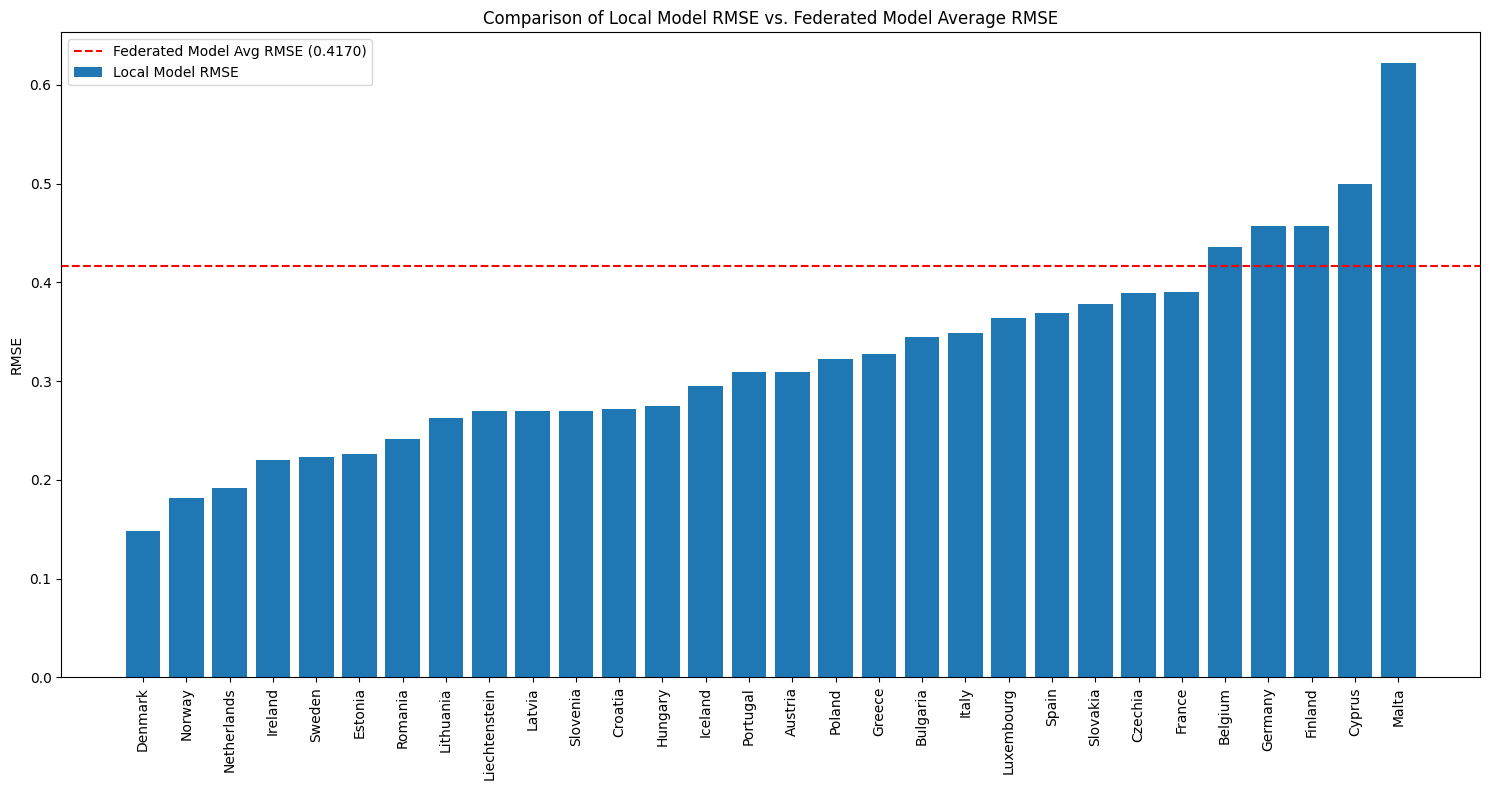

In [14]:
# This code would go in a new cell.

# Create a pandas DataFrame for easy comparison
local_results_df = pd.DataFrame.from_dict(local_model_results, orient='index')
local_results_df = local_results_df.reset_index().rename(columns={'index': 'Country', 'rmse': 'Local_RMSE', 'mae': 'Local_MAE'})

# Calculate the average performance of local models
avg_local_rmse = local_results_df['Local_RMSE'].mean()
avg_local_mae = local_results_df['Local_MAE'].mean()

# Get the federated results from Step 1
avg_federated_rmse =  0.417
avg_federated_mae = 0.766

print("\n--- FINAL COMPARISON ---")
print(f"Average Local Model RMSE: {avg_local_rmse:.4f}")
print(f"Federated Global Model RMSE: {avg_federated_rmse:.4f}")
print("-" * 20)
print(f"Average Local Model MAE: {avg_local_mae:.4f}")
print(f"Federated Global Model MAE: {avg_federated_mae:.4f}")


# Visualize the results
plt.figure(figsize=(15, 8))
local_results_df.sort_values('Local_RMSE', inplace=True)
plt.bar(local_results_df['Country'], local_results_df['Local_RMSE'], label='Local Model RMSE')
plt.axhline(y=avg_federated_rmse, color='r', linestyle='--', label=f'Federated Model Avg RMSE ({avg_federated_rmse:.4f})')
plt.xticks(rotation=90)
plt.title('Comparison of Local Model RMSE vs. Federated Model Average RMSE')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

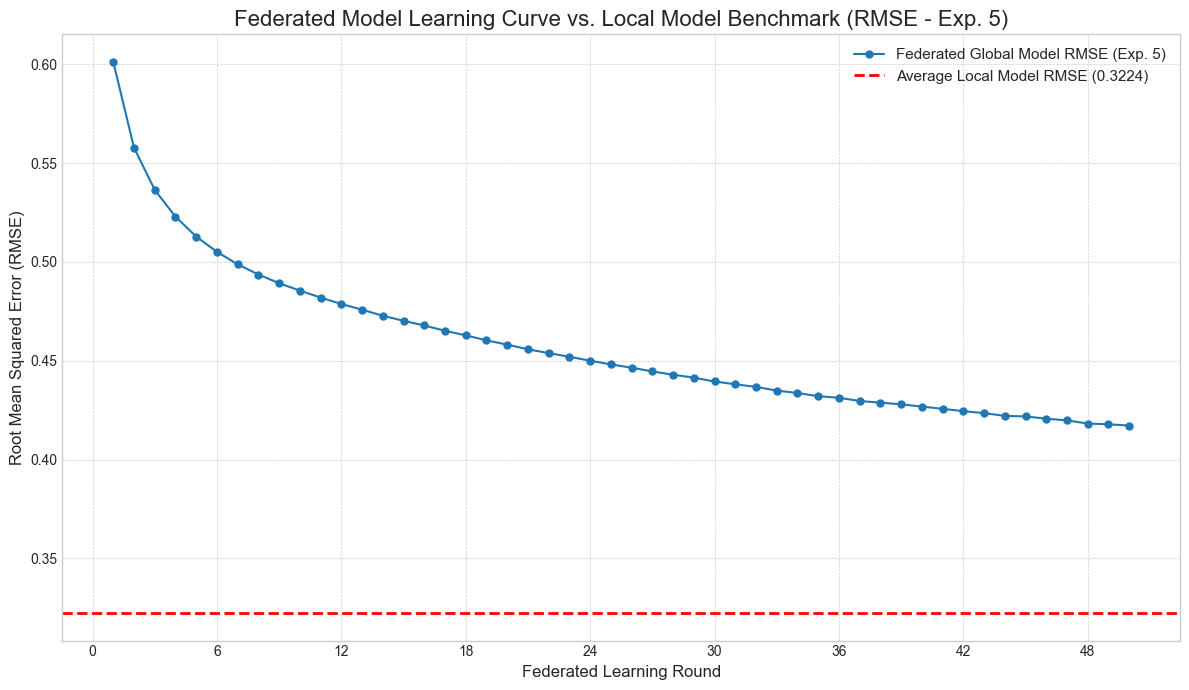

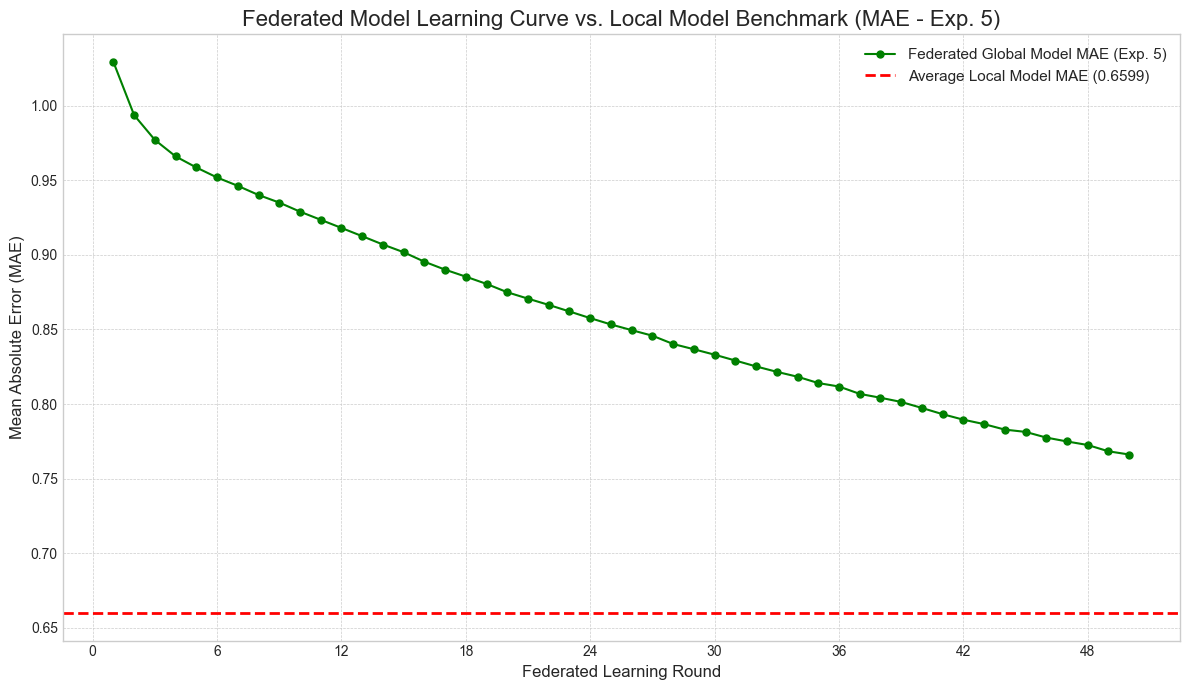

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Manually define the results from your Fifth Experiment ---

# Data for the Federated Global Model (Experiment 5)
rounds = list(range(1, 51))

federated_rmse_history = [
    0.6012083519009276, 0.5578132620571395, 0.5364718326905628, 0.5229021563501851, 0.512851367725401,
    0.5051321456736789, 0.4987980755498226, 0.4936557504135983, 0.48925211306944666, 0.48552861549157156,
    0.48198290458293697, 0.47875348963646347, 0.4758446391349209, 0.4727918133351705, 0.4702437456277581,
    0.4678651723569852, 0.4651984418611693, 0.46287360543785855, 0.46033105443240474, 0.4581820889307552,
    0.45580126020955863, 0.4538904222326096, 0.4520222017584704, 0.45004691956197407, 0.4481484443252287,
    0.446525316732402, 0.44461162775548896, 0.4429434940140147, 0.4414596660028584, 0.4395250059715758,
    0.43811077653949654, 0.4367998673112085, 0.43491527712068795, 0.4336878006877139, 0.43209778749879757,
    0.431306297663219, 0.4296329523330299, 0.42882873063991106, 0.4279581412957809, 0.42683953851546247,
    0.4256891194108348, 0.4245083729102874, 0.4235282439000726, 0.4221260679863778, 0.42186192467039124,
    0.42069723461642894, 0.4198622237065305, 0.41823510964404476, 0.41787157232269806, 0.41723754351194337
]

federated_mae_history = [
    1.0293836357051545, 0.9937151726206516, 0.9771266807720592, 0.9660712820865992, 0.9586313229210254,
    0.9519164712024734, 0.9463242511528205, 0.9401817355712481, 0.93509805876339, 0.9290194425606155,
    0.9235584922513617, 0.9180942812117197, 0.9125743126811027, 0.906975321553499, 0.9018098295534854,
    0.8954495996806426, 0.8901099682872302, 0.8854210562170788, 0.8805552282533107, 0.8749616963197274,
    0.8706628154234558, 0.8664768549328463, 0.8620734981716819, 0.8576144484205428, 0.8533658941328259,
    0.8495463300594812, 0.845826160961072, 0.8402692911682114, 0.8367387222148093, 0.833088994268578,
    0.8291740749075239, 0.8252278284941228, 0.8216022140808152, 0.8183169196707876, 0.8140712394710478,
    0.8117477240335559, 0.8068103381849586, 0.8042222461161356, 0.8014025806217185, 0.7973712160365278,
    0.7931937696294796, 0.7895037182926792, 0.7865313286338215, 0.7828485852288444, 0.7813196504149994,
    0.7775037660255525, 0.7748998440393058, 0.7725227444139909, 0.7682947690601318, 0.7661497412100222
]

# Data for the Average of Local Models (to match this FL experiment)
avg_local_rmse = 0.3224
avg_local_mae = 0.6599


# --- Step 2: Create the RMSE Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the federated model's RMSE at each round
ax.plot(rounds, federated_rmse_history, marker='o', linestyle='-', label='Federated Global Model RMSE (Exp. 5)', markersize=5)

# Plot the average local model performance as a horizontal line for comparison
ax.axhline(y=avg_local_rmse, color='r', linestyle='--', linewidth=2, 
           label=f'Average Local Model RMSE ({avg_local_rmse:.4f})')

ax.set_title('Federated Model Learning Curve vs. Local Model Benchmark (RMSE - Exp. 5)', fontsize=16)
ax.set_xlabel('Federated Learning Round', fontsize=12)
ax.set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


# --- Step 3: Create the MAE Plot ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the federated model's MAE at each round
ax.plot(rounds, federated_mae_history, marker='o', linestyle='-', label='Federated Global Model MAE (Exp. 5)', color='green', markersize=5)
    
# Plot the average local model performance as a horizontal line
ax.axhline(y=avg_local_mae, color='r', linestyle='--', linewidth=2, 
           label=f'Average Local Model MAE ({avg_local_mae:.4f})')

ax.set_title('Federated Model Learning Curve vs. Local Model Benchmark (MAE - Exp. 5)', fontsize=16)
ax.set_xlabel('Federated Learning Round', fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

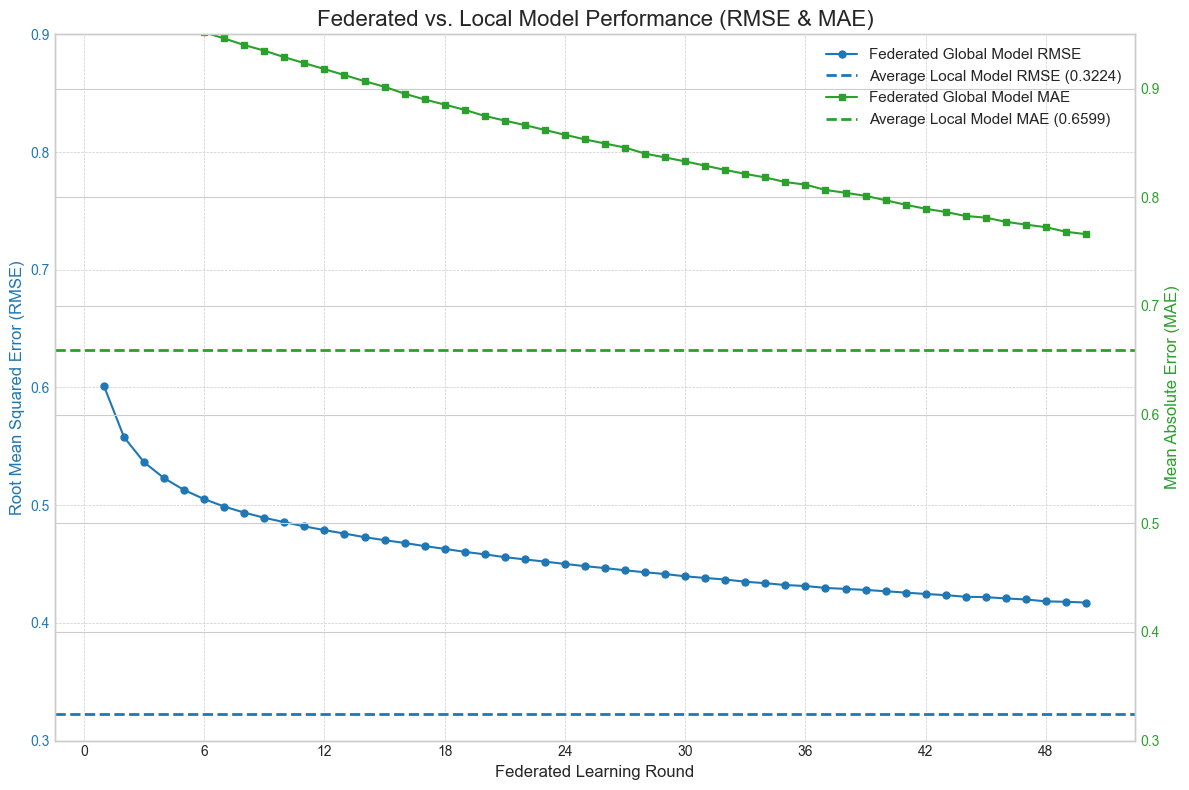

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Data Definition (Unchanged) ---
rounds = list(range(1, 51))
federated_rmse_history = [
    0.6012083519009276, 0.5578132620571395, 0.5364718326905628, 0.5229021563501851, 0.512851367725401,
    0.5051321456736789, 0.4987980755498226, 0.4936557504135983, 0.48925211306944666, 0.48552861549157156,
    0.48198290458293697, 0.47875348963646347, 0.4758446391349209, 0.4727918133351705, 0.4702437456277581,
    0.4678651723569852, 0.4651984418611693, 0.46287360543785855, 0.46033105443240474, 0.4581820889307552,
    0.45580126020955863, 0.4538904222326096, 0.4520222017584704, 0.45004691956197407, 0.4481484443252287,
    0.446525316732402, 0.44461162775548896, 0.4429434940140147, 0.4414596660028584, 0.4395250059715758,
    0.43811077653949654, 0.4367998673112085, 0.43491527712068795, 0.4336878006877139, 0.43209778749879757,
    0.431306297663219, 0.4296329523330299, 0.42882873063991106, 0.4279581412957809, 0.42683953851546247,
    0.4256891194108348, 0.4245083729102874, 0.4235282439000726, 0.4221260679863778, 0.42186192467039124,
    0.42069723461642894, 0.4198622237065305, 0.41823510964404476, 0.41787157232269806, 0.41723754351194337
]
federated_mae_history = [
    1.0293836357051545, 0.9937151726206516, 0.9771266807720592, 0.9660712820865992, 0.9586313229210254,
    0.9519164712024734, 0.9463242511528205, 0.9401817355712481, 0.93509805876339, 0.9290194425606155,
    0.9235584922513617, 0.9180942812117197, 0.9125743126811027, 0.906975321553499, 0.9018098295534854,
    0.8954495996806426, 0.8901099682872302, 0.8854210562170788, 0.8805552282533107, 0.8749616963197274,
    0.8706628154234558, 0.8664768549328463, 0.8620734981716819, 0.8576144484205428, 0.8533658941328259,
    0.8495463300594812, 0.845826160961072, 0.8402692911682114, 0.8367387222148093, 0.833088994268578,
    0.8291740749075239, 0.8252278284941228, 0.8216022140808152, 0.8183169196707876, 0.8140712394710478,
    0.8117477240335559, 0.8068103381849586, 0.8042222461161356, 0.8014025806217185, 0.7973712160365278,
    0.7931937696294796, 0.7895037182926792, 0.7865313286338215, 0.7828485852288444, 0.7813196504149994,
    0.7775037660255525, 0.7748998440393058, 0.7725227444139909, 0.7682947690601318, 0.7661497412100222
]
avg_local_rmse = 0.3224
avg_local_mae = 0.6599


# --- Step 2: Create the Combined Plot (Corrected for Clarity) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(12, 8))

# --- Plotting on the Primary Y-Axis (RMSE) ---
color_rmse = 'tab:blue'
ax1.set_xlabel('Federated Learning Round', fontsize=12)
ax1.set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12, color=color_rmse)
ax1.plot(rounds, federated_rmse_history, marker='o', linestyle='-', label='Federated Global Model RMSE', color=color_rmse, markersize=5)
# MODIFIED LINE: Added the value to the label for clarity
ax1.axhline(y=avg_local_rmse, color=color_rmse, linestyle='--', linewidth=2, 
            label=f'Average Local Model RMSE ({avg_local_rmse:.4f})')
ax1.tick_params(axis='y', labelcolor=color_rmse)
ax1.set_ylim(0.30, 0.9)

# --- Create the Secondary Y-Axis (MAE) ---
ax2 = ax1.twinx()  
color_mae = 'tab:green'
ax2.set_ylabel('Mean Absolute Error (MAE)', fontsize=12, color=color_mae)
ax2.plot(rounds, federated_mae_history, marker='s', linestyle='-', label='Federated Global Model MAE', color=color_mae, markersize=5)
# MODIFIED LINE: Added the value to the label for clarity
ax2.axhline(y=avg_local_mae, color=color_mae, linestyle='--', linewidth=2, 
            label=f'Average Local Model MAE ({avg_local_mae:.4f})')
ax2.tick_params(axis='y', labelcolor=color_mae)
ax2.set_ylim(0.30, 0.95)

# --- Final Plot Adjustments ---
plt.title('Federated vs. Local Model Performance (RMSE & MAE)', fontsize=16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a single combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)

fig.tight_layout()  
plt.show()

In [ ]:
# INFO :          History (metrics, distributed, fit):
# INFO :          {'fit_loss': [(1, 0.6876749033024732),
# INFO :                        (2, 0.5684834796062606),
# INFO :                        (3, 0.5330408550777173),
# INFO :                        (4, 0.5142780664655041),
# INFO :                        (5, 0.5017217693593159),
# INFO :                        (6, 0.49074960144863455),
# INFO :                        (7, 0.48299007442970865),
# INFO :                        (8, 0.47625386897847677),
# INFO :                        (9, 0.47078077120411554),
# INFO :                        (10, 0.46417402357770055),
# INFO :                        (11, 0.45930265569309714),
# INFO :                        (12, 0.4548376882208785),
# INFO :                        (13, 0.4498463485222124),
# INFO :                        (14, 0.44621165415147807),
# INFO :                        (15, 0.4417640443316572),
# INFO :                        (16, 0.43726250468936273),
# INFO :                        (17, 0.4336948447251202),
# INFO :                        (18, 0.42944389887036233),
# INFO :                        (19, 0.42588991334154097),
# INFO :                        (20, 0.4228276591005895),
# INFO :                        (21, 0.41922112980112997),
# INFO :                        (22, 0.41647201565211184),
# INFO :                        (23, 0.4138443951643449),
# INFO :                        (24, 0.41059368772461674),
# INFO :                        (25, 0.4083755045426074),
# INFO :                        (26, 0.4054981565166864),
# INFO :                        (27, 0.4028448726660855),
# INFO :                        (28, 0.4004121567591612),
# INFO :                        (29, 0.3978122590190722),
# INFO :                        (30, 0.3953336252282381),
# INFO :                        (31, 0.39283818737469967),
# INFO :                        (32, 0.39128853187979173),
# INFO :                        (33, 0.3888008095645208),
# INFO :                        (34, 0.38634474572913147),
# INFO :                        (35, 0.3843651856046526),
# INFO :                        (36, 0.38221525974490905),
# INFO :                        (37, 0.37996894793045777),
# INFO :                        (38, 0.3784956066193812),
# INFO :                        (39, 0.3755350575072871),
# INFO :                        (40, 0.3740592578770412),
# INFO :                        (41, 0.37207890339967514),
# INFO :                        (42, 0.3693467058154776),
# INFO :                        (43, 0.3672119244541008),
# INFO :                        (44, 0.364774699809229),
# INFO :                        (45, 0.3626551777639896),
# INFO :                        (46, 0.35983697790467895),
# INFO :                        (47, 0.35800781815464516),
# INFO :                        (48, 0.3551907508913171),
# INFO :                        (49, 0.35266359538417935),
# INFO :                        (50, 0.35087497544241375)],
# INFO :           'fit_val_loss': [(1, 0.5335379756638704),
# INFO :                            (2, 0.5016454020081044),
# INFO :                            (3, 0.48970599121004305),
# INFO :                            (4, 0.48147541804338123),
# INFO :                            (5, 0.4760854163641842),
# INFO :                            (6, 0.4697710475868993),
# INFO :                            (7, 0.4665424313703048),
# INFO :                            (8, 0.4620831402147322),
# INFO :                            (9, 0.45837584439333917),
# INFO :                            (10, 0.4544515427975657),
# INFO :                            (11, 0.45115863903879116),
# INFO :                            (12, 0.4482159398856126),
# INFO :                            (13, 0.4440865109830257),
# INFO :                            (14, 0.44131851141148914),
# INFO :                            (15, 0.4384639108216215),
# INFO :                            (16, 0.43573051978455934),
# INFO :                            (17, 0.43267776347899795),
# INFO :                            (18, 0.4307533665937211),
# INFO :                            (19, 0.4283960520533067),
# INFO :                            (20, 0.42640138668422173),
# INFO :                            (21, 0.4237248825163672),
# INFO :                            (22, 0.42196403971062013),
# INFO :                            (23, 0.4200780800853853),
# INFO :                            (24, 0.41853660865202),
# INFO :                            (25, 0.41769074160668945),
# INFO :                            (26, 0.41571880456458515),
# INFO :                            (27, 0.41451701595779805),
# INFO :                            (28, 0.41145122231602893),
# INFO :                            (29, 0.40999732154626073),
# INFO :                            (30, 0.40716530725579436),
# INFO :                            (31, 0.40730410261262046),
# INFO :                            (32, 0.40580280818215714),
# INFO :                            (33, 0.40346097574202683),
# INFO :                            (34, 0.4022810476924294),
# INFO :                            (35, 0.4011987475893716),
# INFO :                            (36, 0.39863172944361625),
# INFO :                            (37, 0.3954034685589289),
# INFO :                            (38, 0.39607481301495767),
# INFO :                            (39, 0.39402209725354737),
# INFO :                            (40, 0.3923316769932933),
# INFO :                            (41, 0.389348411894143),
# INFO :                            (42, 0.3878221651405628),
# INFO :                            (43, 0.38533805062885107),
# INFO :                            (44, 0.3822908938219504),
# INFO :                            (45, 0.38112487643406895),
# INFO :                            (46, 0.37787101841611875),
# INFO :                            (47, 0.37603854140881526),
# INFO :                            (48, 0.3741739995144248),
# INFO :                            (49, 0.37280491177829167),
# INFO :                            (50, 0.3700555050331838)],
# INFO :           'fit_val_mae': [(1, 0.5335379756638704),
# INFO :                           (2, 0.5016454020081044),
# INFO :                           (3, 0.48970599121004305),
# INFO :                           (4, 0.4814754190604621),
# INFO :                           (5, 0.4760854163641842),
# INFO :                           (6, 0.4697710475868993),
# INFO :                           (7, 0.4665424313703048),
# INFO :                           (8, 0.4620831402147322),
# INFO :                           (9, 0.45837584439333917),
# INFO :                           (10, 0.4544515427975657),
# INFO :                           (11, 0.4511586370023126),
# INFO :                           (12, 0.4482159398856126),
# INFO :                           (13, 0.4440865109830257),
# INFO :                           (14, 0.44131851141148914),
# INFO :                           (15, 0.4384639108216215),
# INFO :                           (16, 0.43573051978455934),
# INFO :                           (17, 0.43267776347899795),
# INFO :                           (18, 0.4307533665937211),
# INFO :                           (19, 0.4283960520533067),
# INFO :                           (20, 0.4264013887160666),
# INFO :                           (21, 0.4237248805563435),
# INFO :                           (22, 0.42196403971062013),
# INFO :                           (23, 0.42007808110246614),
# INFO :                           (24, 0.4185366096355071),
# INFO :                           (25, 0.41769074160668945),
# INFO :                           (26, 0.41571880456458515),
# INFO :                           (27, 0.41451701595779805),
# INFO :                           (28, 0.41145122231602893),
# INFO :                           (29, 0.40999732154626073),
# INFO :                           (30, 0.40716530725579436),
# INFO :                           (31, 0.40730410261262046),
# INFO :                           (32, 0.40580280818215714),
# INFO :                           (33, 0.40346097574202683),
# INFO :                           (34, 0.4022810476924294),
# INFO :                           (35, 0.4011987496258501),
# INFO :                           (36, 0.39863172944361625),
# INFO :                           (37, 0.3954034685589289),
# INFO :                           (38, 0.39607481301495767),
# INFO :                           (39, 0.39402209725354737),
# INFO :                           (40, 0.3923316769932933),
# INFO :                           (41, 0.389348411894143),
# INFO :                           (42, 0.3878221651405628),
# INFO :                           (43, 0.38533805062885107),
# INFO :                           (44, 0.3822908938219504),
# INFO :                           (45, 0.38112487643406895),
# INFO :                           (46, 0.37787101841611875),
# INFO :                           (47, 0.37603854140881526),
# INFO :                           (48, 0.3741739995144248),
# INFO :                           (49, 0.37280491177829167),
# INFO :                           (50, 0.3700555050331838)],
# INFO :           'fit_val_rmse': [(1, 1.0832202893083398),
# INFO :                            (2, 1.0630470389745625),
# INFO :                            (3, 1.0564384563107196),
# INFO :                            (4, 1.0506413892660416),
# INFO :                            (5, 1.0473147430704242),
# INFO :                            (6, 1.0414274649831905),
# INFO :                            (7, 1.038527959867146),
# INFO :                            (8, 1.0312348623501322),
# INFO :                            (9, 1.025749923930174),
# INFO :                            (10, 1.0187396910362305),
# INFO :                            (11, 1.0119180381958357),
# INFO :                            (12, 1.005463936726731),
# INFO :                            (13, 0.9986366986436044),
# INFO :                            (14, 0.9913835657293012),
# INFO :                            (15, 0.985718503752521),
# INFO :                            (16, 0.9782576753941465),
# INFO :                            (17, 0.9718456429699731),
# INFO :                            (18, 0.9659953062554812),
# INFO :                            (19, 0.9615309745954865),
# INFO :                            (20, 0.954630164052991),
# INFO :                            (21, 0.9495448546848504),
# INFO :                            (22, 0.9438495169032693),
# INFO :                            (23, 0.9397551878373362),
# INFO :                            (24, 0.9336236174387303),
# INFO :                            (25, 0.9301682156187926),
# INFO :                            (26, 0.9266650615702444),
# INFO :                            (27, 0.9215156950484295),
# INFO :                            (28, 0.9112253518618793),
# INFO :                            (29, 0.9078827152948816),
# INFO :                            (30, 0.9020940905576099),
# INFO :                            (31, 0.8986893460804979),
# INFO :                            (32, 0.8926694536348578),
# INFO :                            (33, 0.8858168507229783),
# INFO :                            (34, 0.8824228603595126),
# INFO :                            (35, 0.8774243496628014),
# INFO :                            (36, 0.8733738897451645),
# INFO :                            (37, 0.8634913873741064),
# INFO :                            (38, 0.8610978970007942),
# INFO :                            (39, 0.8567541839881649),
# INFO :                            (40, 0.8481125556517227),
# INFO :                            (41, 0.8406389989968097),
# INFO :                            (42, 0.8353328909593906),
# INFO :                            (43, 0.8294809394483362),
# INFO :                            (44, 0.8187579264697153),
# INFO :                            (45, 0.8165017394129968),
# INFO :                            (46, 0.8051854092697992),
# INFO :                            (47, 0.7995032173763762),
# INFO :                            (48, 0.793832644374806),
# INFO :                            (49, 0.7880619863603434),
# INFO :                            (50, 0.7795902014777233)]}
# INFO :          History (metrics, distributed, evaluate):
# INFO :          {'eval_mae': [(1, 1.0293836357051545),
# INFO :                        (2, 0.9937151726206516),
# INFO :                        (3, 0.9771266807720592),
# INFO :                        (4, 0.9660712820865992),
# INFO :                        (5, 0.9586313229210254),
# INFO :                        (6, 0.9519164712024734),
# INFO :                        (7, 0.9463242511528205),
# INFO :                        (8, 0.9401817355712481),
# INFO :                        (9, 0.93509805876339),
# INFO :                        (10, 0.9290194425606155),
# INFO :                        (11, 0.9235584922513617),
# INFO :                        (12, 0.9180942812117197),
# INFO :                        (13, 0.9125743126811027),
# INFO :                        (14, 0.906975321553499),
# INFO :                        (15, 0.9018098295534854),
# INFO :                        (16, 0.8954495996806426),
# INFO :                        (17, 0.8901099682872302),
# INFO :                        (18, 0.8854210562170788),
# INFO :                        (19, 0.8805552282533107),
# INFO :                        (20, 0.8749616963197274),
# INFO :                        (21, 0.8706628154234558),
# INFO :                        (22, 0.8664768549328463),
# INFO :                        (23, 0.8620734981716819),
# INFO :                        (24, 0.8576144484205428),
# INFO :                        (25, 0.8533658941328259),
# INFO :                        (26, 0.8495463300594812),
# INFO :                        (27, 0.845826160961072),
# INFO :                        (28, 0.8402692911682114),
# INFO :                        (29, 0.8367387222148093),
# INFO :                        (30, 0.833088994268578),
# INFO :                        (31, 0.8291740749075239),
# INFO :                        (32, 0.8252278284941228),
# INFO :                        (33, 0.8216022140808152),
# INFO :                        (34, 0.8183169196707876),
# INFO :                        (35, 0.8140712394710478),
# INFO :                        (36, 0.8117477240335559),
# INFO :                        (37, 0.8068103381849586),
# INFO :                        (38, 0.8042222461161356),
# INFO :                        (39, 0.8014025806217185),
# INFO :                        (40, 0.7973712160365278),
# INFO :                        (41, 0.7931937696294796),
# INFO :                        (42, 0.7895037182926792),
# INFO :                        (43, 0.7865313286338215),
# INFO :                        (44, 0.7828485852288444),
# INFO :                        (45, 0.7813196504149994),
# INFO :                        (46, 0.7775037660255525),
# INFO :                        (47, 0.7748998440393058),
# INFO :                        (48, 0.7725227444139909),
# INFO :                        (49, 0.7682947690601318),
# INFO :                        (50, 0.7661497412100222)],
# INFO :           'eval_rmse': [(1, 0.6012083519009276),
# INFO :                         (2, 0.5578132620571395),
# INFO :                         (3, 0.5364718326905628),
# INFO :                         (4, 0.5229021563501851),
# INFO :                         (5, 0.512851367725401),
# INFO :                         (6, 0.5051321456736789),
# INFO :                         (7, 0.4987980755498226),
# INFO :                         (8, 0.4936557504135983),
# INFO :                         (9, 0.48925211306944666),
# INFO :                         (10, 0.48552861549157156),
# INFO :                         (11, 0.48198290458293697),
# INFO :                         (12, 0.47875348963646347),
# INFO :                         (13, 0.4758446391349209),
# INFO :                         (14, 0.4727918133351705),
# INFO :                         (15, 0.4702437456277581),
# INFO :                         (16, 0.4678651723569852),
# INFO :                         (17, 0.4651984418611693),
# INFO :                         (18, 0.46287360543785855),
# INFO :                         (19, 0.46033105443240474),
# INFO :                         (20, 0.4581820889307552),
# INFO :                         (21, 0.45580126020955863),
# INFO :                         (22, 0.4538904222326096),
# INFO :                         (23, 0.4520222017584704),
# INFO :                         (24, 0.45004691956197407),
# INFO :                         (25, 0.4481484443252287),
# INFO :                         (26, 0.446525316732402),
# INFO :                         (27, 0.44461162775548896),
# INFO :                         (28, 0.4429434940140147),
# INFO :                         (29, 0.4414596660028584),
# INFO :                         (30, 0.4395250059715758),
# INFO :                         (31, 0.43811077653949654),
# INFO :                         (32, 0.4367998673112085),
# INFO :                         (33, 0.43491527712068795),
# INFO :                         (34, 0.4336878006877139),
# INFO :                         (35, 0.43209778749879757),
# INFO :                         (36, 0.431306297663219),
# INFO :                         (37, 0.4296329523330299),
# INFO :                         (38, 0.42882873063991106),
# INFO :                         (39, 0.4279581412957809),
# INFO :                         (40, 0.42683953851546247),
# INFO :                         (41, 0.4256891194108348),
# INFO :                         (42, 0.4245083729102874),
# INFO :                         (43, 0.4235282439000726),
# INFO :                         (44, 0.4221260679863778),
# INFO :                         (45, 0.42186192467039124),
# INFO :                         (46, 0.42069723461642894),
# INFO :                         (47, 0.4198622237065305),
# INFO :                         (48, 0.41823510964404476),
# INFO :                         (49, 0.41787157232269806),
# INFO :                         (50, 0.41723754351194337)]}
# INFO :
# 20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4044 - mean_absolute_error: 0.4044 - root_mean_squared_error: 0.6812 
# 27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.4002 - mean_absolute_error: 0.4002 - root_mean_squared_error: 0.6769 - val_loss: 0.4728 - val_mean_absolute_error: 0.4728 - val_root_mean_squared_error: 0.8951 [repeated 3x across cluster]
# 3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3167 - mean_absolute_error: 0.3167 - root_mean_squared_error: 0.7823  [repeated 18x across cluster]
# 27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.3091 - mean_absolute_error: 0.3091 - root_mean_squared_error: 0.6848 - val_loss: 0.2690 - val_mean_absolute_error: 0.2690 - val_root_mean_squared_error: 0.5563 [repeated 2x across cluster]
# 1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.3682 - mean_absolute_error: 0.3682 - root_mean_squared_error: 0.6597 [repeated 16x across cluster]
# 3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3947 - mean_absolute_error: 0.3947 - root_mean_squared_error: 0.7759  [repeated 14x across cluster]
# 26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3096 - mean_absolute_error: 0.3096 - root_mean_squared_error: 0.6861 [repeated 2x across cluster]
# 21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3109 - mean_absolute_error: 0.3109 - root_mean_squared_error: 0.6907 [repeated 5x across cluster]
# (ClientAppActor pid=2744326) WARNING:tensorflow:5 out of the last 37 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x715b2c239240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details. [repeated 3x across cluster]
# Total FL training time: 375.41772079467773 seconds

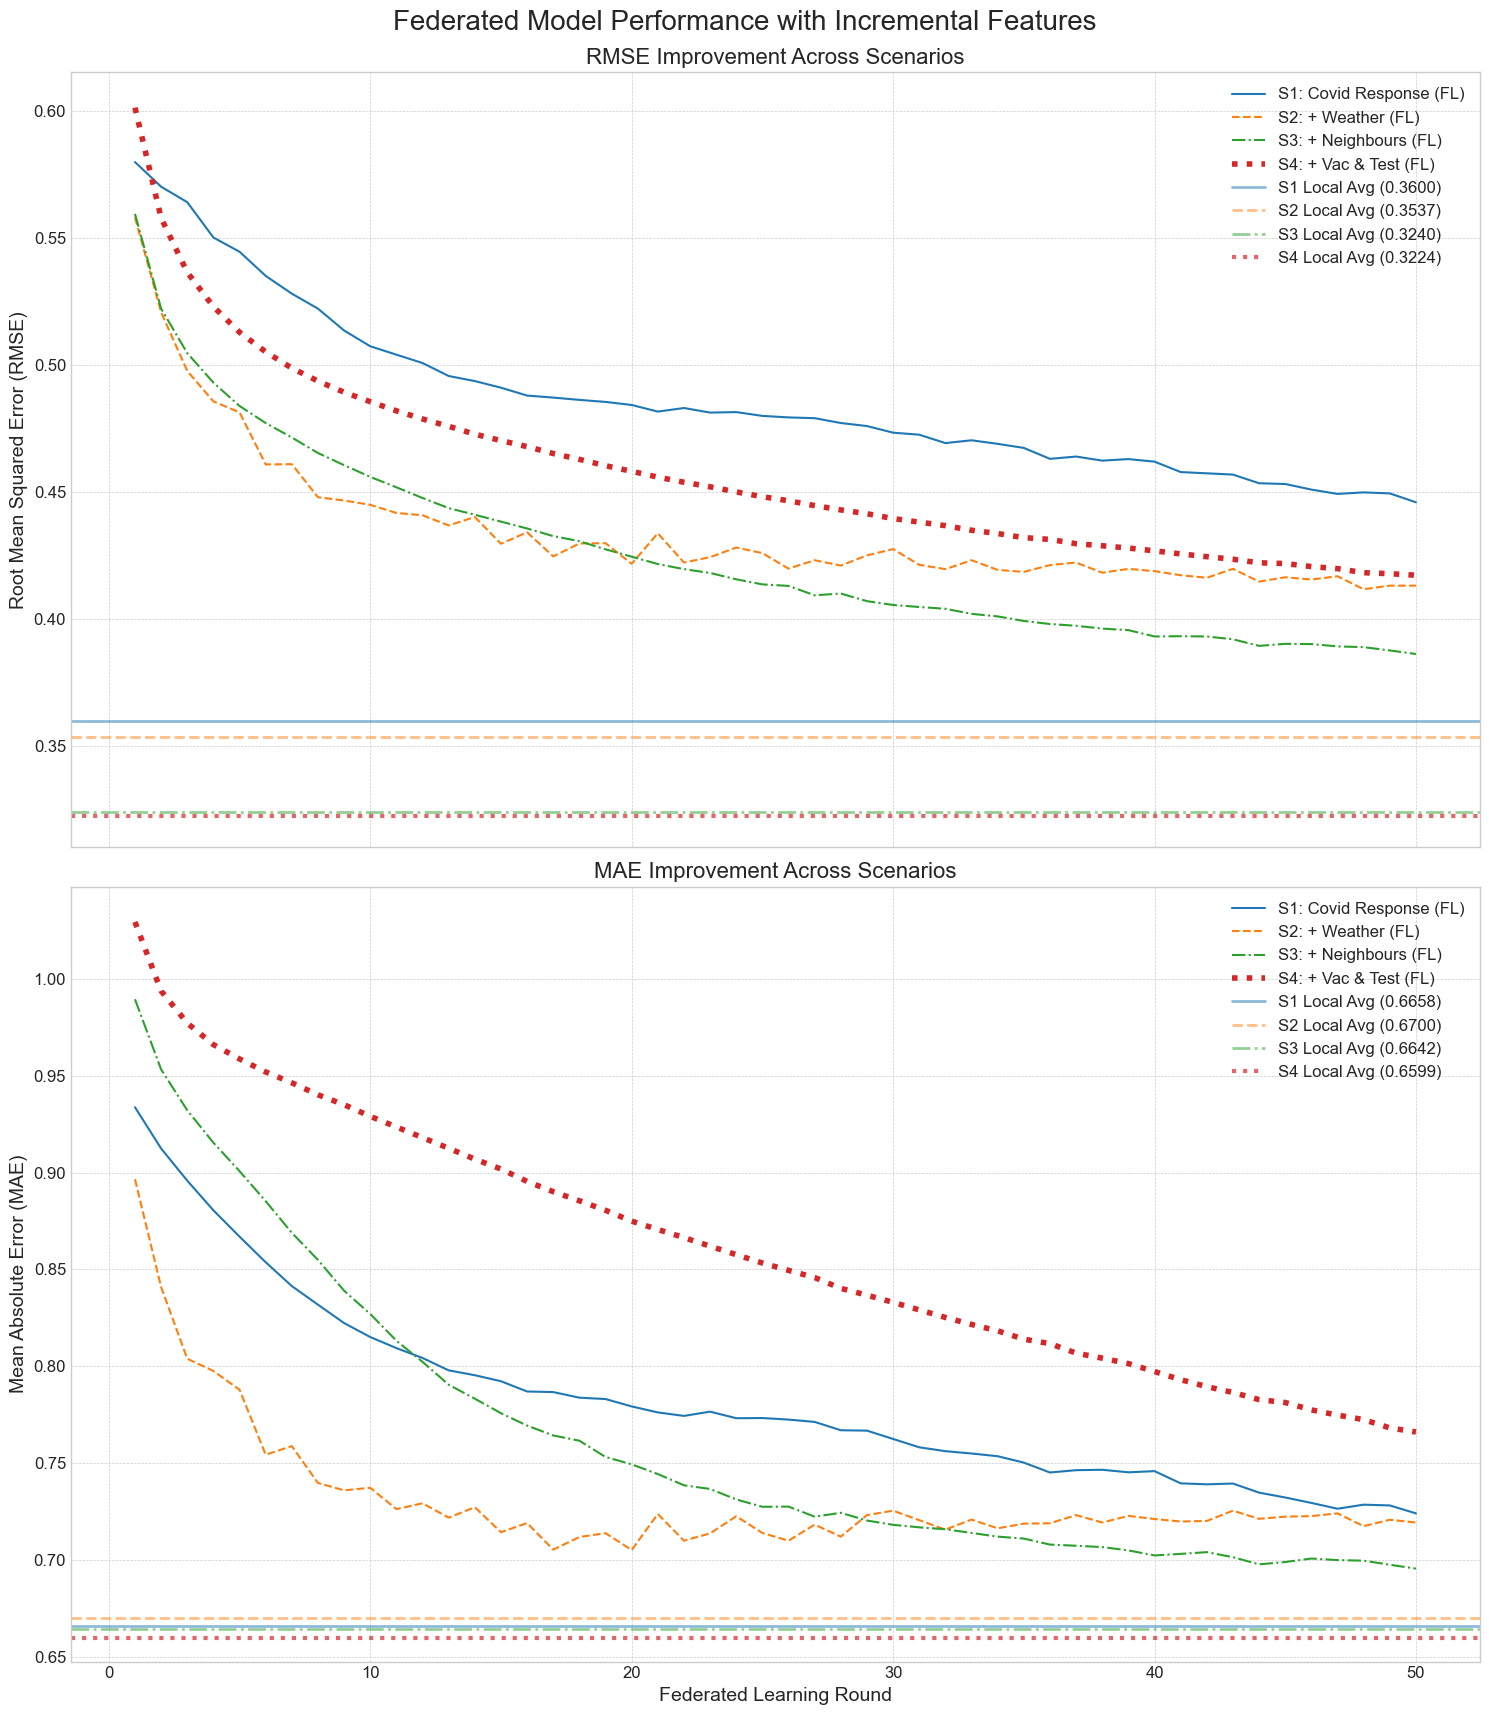

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Define the complete data from all four experiments ---

# Common x-axis for all plots
rounds = list(range(1, 51))

# --- Data for Scenario 1: covid_response ---
mae_s1 = [
    0.9337, 0.9124, 0.8958, 0.8805, 0.8669, 0.8537, 0.8414, 0.8318, 0.8223, 0.8151,
    0.8094, 0.8043, 0.7979, 0.7954, 0.7923, 0.7870, 0.7867, 0.7838, 0.7831, 0.7793,
    0.7762, 0.7744, 0.7766, 0.7732, 0.7733, 0.7725, 0.7713, 0.7670, 0.7668, 0.7625,
    0.7582, 0.7562, 0.7550, 0.7536, 0.7503, 0.7452, 0.7464, 0.7466, 0.7453, 0.7459,
    0.7396, 0.7391, 0.7395, 0.7348, 0.7323, 0.7295, 0.7265, 0.7286, 0.7282, 0.7241
]
rmse_s1 = [
    0.5798, 0.5701, 0.5640, 0.5501, 0.5445, 0.5350, 0.5280, 0.5221, 0.5135, 0.5073,
    0.5040, 0.5007, 0.4956, 0.4936, 0.4910, 0.4879, 0.4871, 0.4862, 0.4854, 0.4842,
    0.4816, 0.4830, 0.4812, 0.4814, 0.4799, 0.4793, 0.4790, 0.4771, 0.4759, 0.4733,
    0.4725, 0.4692, 0.4703, 0.4689, 0.4673, 0.4630, 0.4639, 0.4623, 0.4629, 0.4619,
    0.4578, 0.4573, 0.4568, 0.4534, 0.4531, 0.4509, 0.4492, 0.4498, 0.4494, 0.4459
]
local_rmse_s1 = 0.3600
local_mae_s1 = 0.6658

# --- Data for Scenario 2: covid_response_weather ---
mae_s2 = [
    0.8965, 0.8409, 0.8039, 0.7976, 0.7879, 0.7544, 0.7588, 0.7398, 0.7360, 0.7373,
    0.7263, 0.7293, 0.7219, 0.7273, 0.7144, 0.7191, 0.7054, 0.7119, 0.7139, 0.7052,
    0.7238, 0.7100, 0.7138, 0.7226, 0.7140, 0.7100, 0.7183, 0.7121, 0.7232, 0.7255,
    0.7206, 0.7157, 0.7209, 0.7164, 0.7188, 0.7190, 0.7232, 0.7194, 0.7228, 0.7212,
    0.7199, 0.7202, 0.7255, 0.7213, 0.7224, 0.7227, 0.7241, 0.7175, 0.7208, 0.7194
]
rmse_s2 = [
    0.5580, 0.5207, 0.4976, 0.4856, 0.4813, 0.4608, 0.4609, 0.4479, 0.4466, 0.4449,
    0.4417, 0.4408, 0.4368, 0.4401, 0.4296, 0.4341, 0.4246, 0.4297, 0.4298, 0.4217,
    0.4337, 0.4222, 0.4243, 0.4281, 0.4259, 0.4198, 0.4231, 0.4210, 0.4250, 0.4275,
    0.4213, 0.4196, 0.4231, 0.4193, 0.4185, 0.4212, 0.4222, 0.4182, 0.4197, 0.4188,
    0.4172, 0.4162, 0.4197, 0.4147, 0.4164, 0.4155, 0.4168, 0.4117, 0.4131, 0.4131
]
local_rmse_s2 = 0.3537
local_mae_s2 = 0.6700

# --- Data for Scenario 3: covid_response_weather_avg_neighbour ---
mae_s3 = [
    0.9894, 0.9532, 0.9321, 0.9154, 0.9007, 0.8852, 0.8689, 0.8549, 0.8390, 0.8270,
    0.8132, 0.8023, 0.7905, 0.7833, 0.7758, 0.7694, 0.7643, 0.7616, 0.7532, 0.7494,
    0.7444, 0.7386, 0.7367, 0.7313, 0.7275, 0.7276, 0.7224, 0.7244, 0.7204, 0.7182,
    0.7169, 0.7159, 0.7140, 0.7121, 0.7111, 0.7080, 0.7074, 0.7067, 0.7050, 0.7024,
    0.7032, 0.7041, 0.7015, 0.6978, 0.6990, 0.7008, 0.7000, 0.6997, 0.6976, 0.6956
]
rmse_s3 = [
    0.5594, 0.5221, 0.5046, 0.4930, 0.4838, 0.4771, 0.4714, 0.4653, 0.4605, 0.4559,
    0.4518, 0.4476, 0.4436, 0.4410, 0.4383, 0.4356, 0.4326, 0.4306, 0.4274, 0.4245,
    0.4216, 0.4196, 0.4181, 0.4156, 0.4136, 0.4130, 0.4093, 0.4100, 0.4070, 0.4055,
    0.4047, 0.4040, 0.4020, 0.4010, 0.3992, 0.3980, 0.3973, 0.3962, 0.3956, 0.3931,
    0.3932, 0.3931, 0.3920, 0.3894, 0.3902, 0.3901, 0.3892, 0.3889, 0.3876, 0.3862
]
local_rmse_s3 = 0.3240
local_mae_s3 = 0.6642

# --- Data for Scenario 4: ..._vaccination_testing ---
mae_s4 = [
    1.0293, 0.9937, 0.9771, 0.9660, 0.9586, 0.9519, 0.9463, 0.9401, 0.9350, 0.9290,
    0.9235, 0.9180, 0.9125, 0.9069, 0.9018, 0.8954, 0.8901, 0.8854, 0.8805, 0.8749,
    0.8706, 0.8664, 0.8620, 0.8576, 0.8533, 0.8495, 0.8458, 0.8402, 0.8367, 0.8330,
    0.8291, 0.8252, 0.8216, 0.8183, 0.8140, 0.8117, 0.8068, 0.8042, 0.8014, 0.7973,
    0.7931, 0.7895, 0.7865, 0.7828, 0.7813, 0.7775, 0.7748, 0.7725, 0.7682, 0.7661
]
rmse_s4 = [
    0.6012, 0.5578, 0.5364, 0.5229, 0.5128, 0.5051, 0.4987, 0.4936, 0.4892, 0.4855,
    0.4819, 0.4787, 0.4758, 0.4727, 0.4702, 0.4678, 0.4651, 0.4628, 0.4603, 0.4581,
    0.4558, 0.4538, 0.4520, 0.4500, 0.4481, 0.4465, 0.4446, 0.4429, 0.4414, 0.4395,
    0.4381, 0.4367, 0.4349, 0.4336, 0.4320, 0.4313, 0.4296, 0.4288, 0.4279, 0.4268,
    0.4256, 0.4245, 0.4235, 0.4221, 0.4218, 0.4206, 0.4198, 0.4182, 0.4178, 0.4172
]
local_rmse_s4 = 0.3224
local_mae_s4 = 0.6599


# --- Step 2: Create the plots in a single figure ---
plt.style.use('seaborn-v0_8-whitegrid')
# Create a figure with two subplots, stacked vertically, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 18), sharex=True)
fig.suptitle('Federated Model Performance with Incremental Features', fontsize=20, y=0.95)

# --- Plot 1: RMSE Comparison ---
# Plotting federated learning curves
p1 = ax1.plot(rounds, rmse_s1, linestyle='-', label='S1: Covid Response (FL)')
p2 = ax1.plot(rounds, rmse_s2, linestyle='--', label='S2: + Weather (FL)')
p3 = ax1.plot(rounds, rmse_s3, linestyle='-.', label='S3: + Neighbours (FL)')
p4 = ax1.plot(rounds, rmse_s4, linestyle=':', linewidth=4, label='S4: + Vac & Test (FL)')

# Plotting the corresponding local model baselines with matching colors
ax1.axhline(y=local_rmse_s1, color=p1[0].get_color(), linestyle='-', alpha=0.5, linewidth=2, label=f'S1 Local Avg ({local_rmse_s1:.4f})')
ax1.axhline(y=local_rmse_s2, color=p2[0].get_color(), linestyle='--', alpha=0.5, linewidth=2, label=f'S2 Local Avg ({local_rmse_s2:.4f})')
ax1.axhline(y=local_rmse_s3, color=p3[0].get_color(), linestyle='-.', alpha=0.5, linewidth=2, label=f'S3 Local Avg ({local_rmse_s3:.4f})')
ax1.axhline(y=local_rmse_s4, color=p4[0].get_color(), linestyle=':', alpha=0.7, linewidth=3, label=f'S4 Local Avg ({local_rmse_s4:.4f})')

ax1.set_title('RMSE Improvement Across Scenarios', fontsize=16)
ax1.set_ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=12, loc='upper right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 2: MAE Comparison ---
# Plotting federated learning curves
p1 = ax2.plot(rounds, mae_s1, linestyle='-', label='S1: Covid Response (FL)')
p2 = ax2.plot(rounds, mae_s2, linestyle='--', label='S2: + Weather (FL)')
p3 = ax2.plot(rounds, mae_s3, linestyle='-.', label='S3: + Neighbours (FL)')
p4 = ax2.plot(rounds, mae_s4, linestyle=':', linewidth=4, label='S4: + Vac & Test (FL)')

# Plotting the corresponding local model baselines with matching colors
ax2.axhline(y=local_mae_s1, color=p1[0].get_color(), linestyle='-', alpha=0.5, linewidth=2, label=f'S1 Local Avg ({local_mae_s1:.4f})')
ax2.axhline(y=local_mae_s2, color=p2[0].get_color(), linestyle='--', alpha=0.5, linewidth=2, label=f'S2 Local Avg ({local_mae_s2:.4f})')
ax2.axhline(y=local_mae_s3, color=p3[0].get_color(), linestyle='-.', alpha=0.5, linewidth=2, label=f'S3 Local Avg ({local_mae_s3:.4f})')
ax2.axhline(y=local_mae_s4, color=p4[0].get_color(), linestyle=':', alpha=0.7, linewidth=3, label=f'S4 Local Avg ({local_mae_s4:.4f})')

ax2.set_title('MAE Improvement Across Scenarios', fontsize=16)
ax2.set_xlabel('Federated Learning Round', fontsize=14)
ax2.set_ylabel('Mean Absolute Error (MAE)', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(fontsize=12, loc='upper right')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for the suptitle
plt.show()